> This notebook is inspired by the works of [Ishan Dutta](https://www.kaggle.com/ishandutta). 
You might like his [notebook](https://www.kaggle.com/ishandutta/ag-news-classification-lstm),
where he elaborated theoretical and practical information about Bi-directional LSTM. 
Upvote my notebook if you find it useful

# About the dataset
![image.png](https://i1.adis.ws/i/canon/Digital-Newspaper-Printing-hero-1280x768?w=100%&aspect=16:9&qlt=80&sm=aspect&fmt=jpg&fmt.options=interlaced&fmt=jpg&fmt.options=interlaced&bg=rgb(255,255,255))

### Origin
AG-Corpus is a collection of more than 1 million news articles from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. 

The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).

### Description
The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.
The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to
- class index (1 to 4), 
- title and 
- description.

The class index ranging from 1 to 4 denotes to **World News**, **Sports News**, **Business News** and **Science-Technology News**, respectively.
The title and description are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). 

# My Work
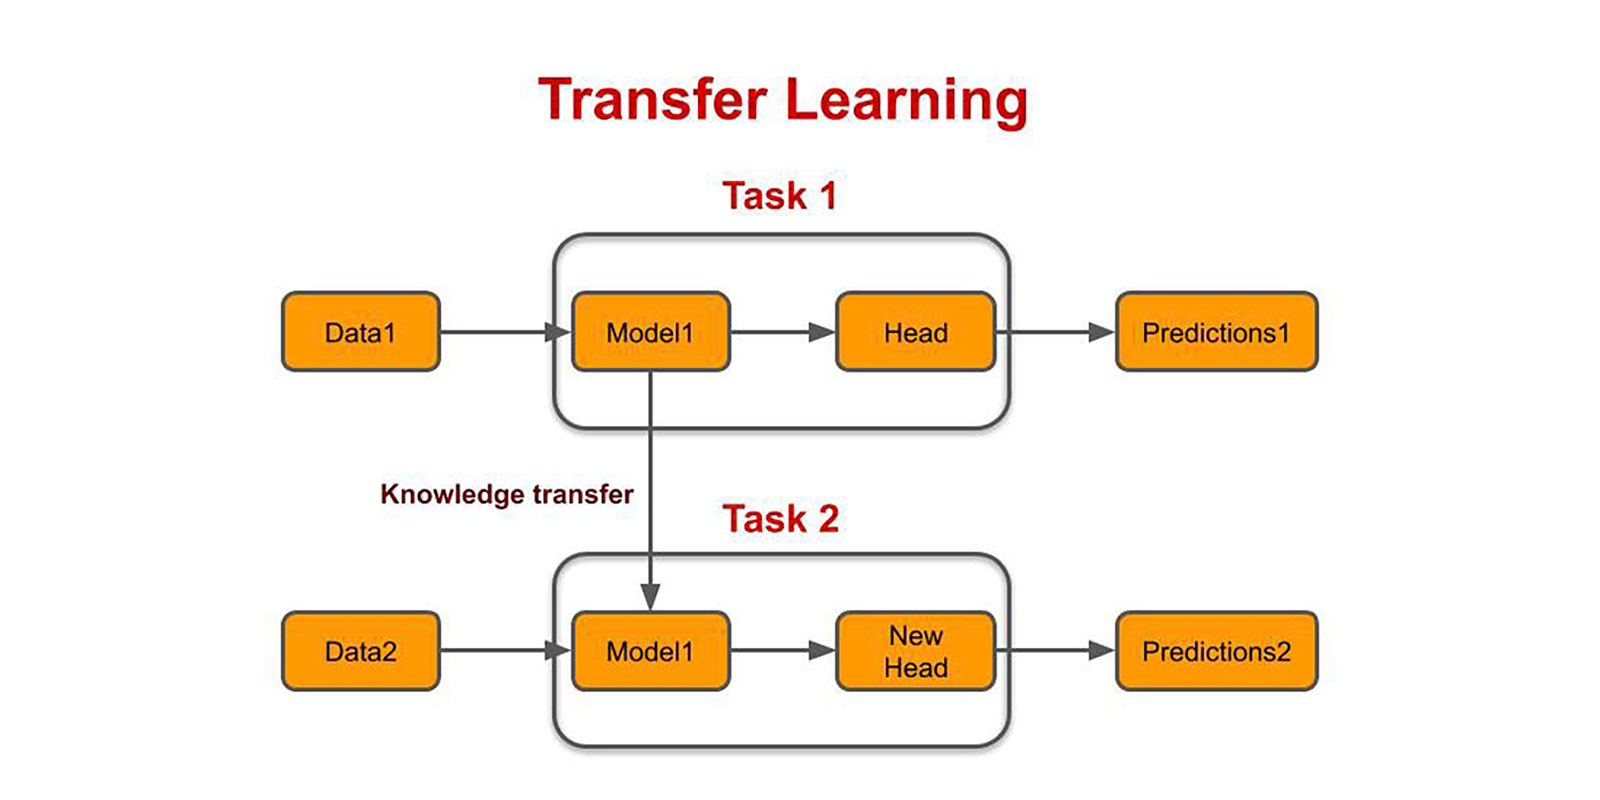
In this notebook I introduce you to the transfer learning methods in NLP. In most of my research I use transfer learning methods(USE, BERT, GloVe etc.) for clustering unstructured textual data, whereas their use-cases could be many like for classification tasks and similar. Let me know if we can use them in other things in the comment.

## Universal Sentence Encoder
If you have been working with any kind of text processing, you would be aware of word embeddings using any of the popular implementations like GloVe, word2vec, fastText. These embeddings are only useful for word level operations, sometimes we would want to explore embeddings for sentences, or generally, greater-than-word length text. In this notebook we will explore sentence encoding with universal-sentence-encoder. This module is part of tensorflow-hub. We will be using the pre-trained model to create embeddings for our sentences. The embeddings vector is 512 length, irrespective of the length of the input.
![](https://www.gstatic.com/aihub/tfhub/universal-sentence-encoder/example-similarity.png)
The Universal Sentence Encoder(USE) encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering, and other natural language tasks. It comes with two variations i.e. one trained with Transformer encoder and other trained with Deep Averaging Network (DAN). The two have a trade-off of accuracy and computational resource requirement. While the one with Transformer encoder has higher accuracy, it is computationally more intensive. The one with DAN encoding is computationally less expensive and with little lower accuracy. For a concise understanding of it's training process and use-cases, I would recommend you to read [the paper](https://arxiv.org/pdf/1803.11175.pdf).

# Importing Packages

In [ ]:
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt

#Text Color
from termcolor import colored

#Train Test Split
from sklearn.model_selection import train_test_split

#Model Evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

#Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow_hub import KerasLayer

# Dataset Loading

In [ ]:
#Load Data
train = pd.read_csv('../input/ag-news-classification-dataset/train.csv')
test = pd.read_csv('../input/ag-news-classification-dataset/test.csv')

#Set Column Names 
train.columns = ['ClassIndex', 'Title', 'Description']
test.columns = ['ClassIndex', 'Title', 'Description']

#Combine Title and Description
X_train = train['Title'] + " " + train['Description'] # Combine title and description (better accuracy than using them as separate features)
y_train = train['ClassIndex'].apply(lambda x: x-1).values # Class labels need to begin from 0

X_test = test['Title'] + " " + test['Description'] # Combine title and description (better accuracy than using them as separate features)
y_test = test['ClassIndex'].apply(lambda x: x-1).values # Class labels need to begin from 0

train.head()

In [ ]:
X_train.shape,X_test.shape

# Network Architecture

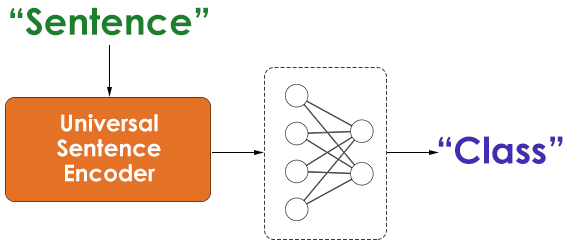
I imported USE as a Keras Layer using Tensorflow APIs, and instead of preprocessing text, which we don't need to do as USE converts them into a global representation, I made the input layer to take string variables. Since I don't need to train USE(it's pretrained), I add fully connected layers to the network with a final classifier of 4 nodes.

In [ ]:
in_layer = Input(shape=[], dtype=tf.string)
embedding_layer = KerasLayer('../input/universalsentenceencodermodels/universal-sentence-encoder-models/use',
                    trainable=True)(in_layer)
d1_layer = Dense(256,activation = 'relu',
    kernel_regularizer=tf.keras.regularizers.L2(0.01))(embedding_layer)
dropout = Dropout(0.2)(d1_layer)
classifier = Dense(4,activation = 'softmax')(dropout)

model = Model(in_layer,classifier)

model.summary()

In [ ]:
callbacks = [
    EarlyStopping(     #EarlyStopping is used to stop at the epoch where val_accuracy does not improve significantly
        monitor='val_loss',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_loss', 
        mode='min', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

## Training the Classifier
![](https://beta.techcrunch.com/wp-content/uploads/2017/04/neural_networks_fully_connected_layers_gumgum1.gif)

We'll train the FC layer in the network including the classifier layer, and also save network weights with best validation accuracy using Tensorflow callback.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer='adam', 
              metrics=['accuracy']) 

history = model.fit(X_train, 
          y_train, 
          batch_size=32, 
          validation_data=(X_test, y_test), 
          epochs=20, 
          callbacks=callbacks)

In [ ]:
model.load_weights('weights.h5')
model.save('model.hdf5')

# Checkout the demo

In [ ]:
## Thanks to Ishan Dutta for his creativity
def modelDemo(news_text):

  #News Labels
  labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']

  test_preds = [labels[np.argmax(i)] for i in model.predict(news_text)]

  for news, label in zip(news_text, test_preds):
      # print('{} - {}'.format(news, label))
      print('{} - {}\n'.format(colored(news, 'yellow'), colored(label, 'blue')))

In [ ]:
modelDemo(['New evidence of virus risks from wildlife trade',
          'Coronavirus: Bank pumps £100bn into UK economy to aid recovery',
          'Trump\'s bid to end Obama-era immigration policy ruled unlawful',
          'David Luiz’s future with Arsenal to be decided this week'])

# Evaluation

In [ ]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
preds = [np.argmax(i) for i in model.predict(X_test)]
cm  = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

In [ ]:
print("Recall of the model is {:.2f}".format(recall_score(y_test, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(y_test, preds, average='micro')))
print("Accuracy of the model is {:.2f}".format(accuracy_score(y_test, preds)))